This file currently requires the these additional packages to run:
```
plotly
ipywidgets
nbformat
nglview=3.0.8
```
(nglview 3.1.2 dies with a JS error when I run it in VSCode)

In [1]:
import mdtraj

from matplotlib import pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
import nglview as nv

import itertools
import numpy as np

In [2]:
native_path = "/media/DATA_18_TB_1/daniel_s/westpa_RMSD_explore/1PEF/bstates/bstate.pdb"
sim_trajectory_path="/media/DATA_18_TB_1/daniel_s/westpa_RMSD_explore/1PEF_all_200iter.h5"


In [3]:
def calculate_q_rmsd(native, sim_traj):
    # https://userguide.mdanalysis.org/1.1.1/examples/analysis/distances_and_contacts/contacts_native_fraction.html

    native_traj = mdtraj.load_frame(native, 0)
    ca_atoms = native_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])
    native_dist = mdtraj.compute_distances(native_traj[0], all_ca_pairs)[0]

    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    all_ca_pairs = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])

    # native_dist = mdtraj.compute_distances(sim_traj[0], all_ca_pairs)[0]
    print(len(all_ca_pairs), len(native_dist))
    native_pairs = all_ca_pairs[native_dist < 0.8]
    print(len(all_ca_pairs),len(native_pairs))

    percent_native = np.sum(mdtraj.compute_distances(sim_traj, native_pairs)<0.8,axis=1)/len(native_pairs)
    rmsd_values = mdtraj.rmsd(sim_traj, sim_traj[0], atom_indices=ca_atoms)
    return(percent_native, rmsd_values)

In [4]:
target_number_of_frames = 10000
traj = mdtraj.load(sim_trajectory_path)
traj[::(len(traj)//target_number_of_frames)]

simulated_traj_values = calculate_q_rmsd(native_path, traj)

/home/md-ml/miniconda3/envs/daniel_s-torchmdnet2/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


306 306
306 132


In [5]:
axis_xmin = np.min(np.concatenate([simulated_traj_values[0]]))-0.05
axis_xmax = np.max(np.concatenate([simulated_traj_values[0]]))+0.05
axis_ymin = np.min(np.concatenate([simulated_traj_values[1]]))-0.05
axis_ymax = np.max(np.concatenate([simulated_traj_values[1]]))+0.05
((axis_xmin, axis_xmax), (axis_ymin, axis_ymax))

((0.6924242424242424, 1.05), (-0.04953964402084239, 0.8640922784805298))

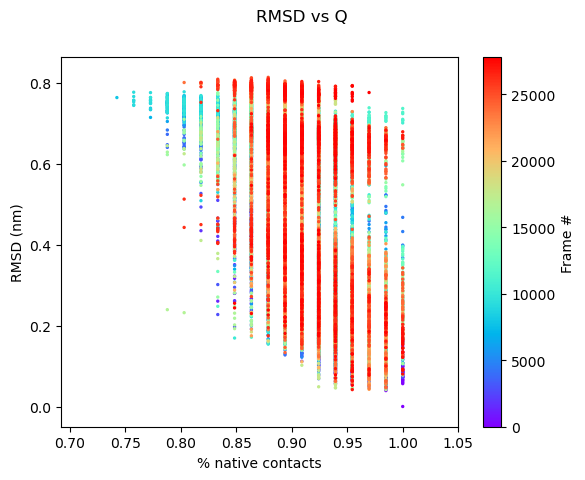

In [6]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('RMSD vs Q')

ax1.set_xlabel("% native contacts")
ax1.set_ylabel("RMSD (nm)")

ax1.set_xlim(axis_xmin, axis_xmax)
ax1.set_ylim(axis_ymin, axis_ymax)

scatter1 = ax1.scatter(simulated_traj_values[0], simulated_traj_values[1], c=range(len(simulated_traj_values[0])), cmap="rainbow", s=2)

fig.colorbar(scatter1, ax=ax1, label="Frame #")
pass

In [10]:
# Mostly from this:
#https://stackoverflow.com/questions/70628787/python-interactive-plotting-with-click-events

scatter_go = go.Scatter(x=simulated_traj_values[0], y=simulated_traj_values[1], mode='markers',
                        text=["Frame %d" % i for i in range(len(simulated_traj_values[0]))],
                        marker=dict(size=5, color=np.linspace(0,1,len(simulated_traj_values[0])), colorscale="Rainbow"))

figure = go.FigureWidget([scatter_go])
figure.update_layout(autosize=False,
                     width=400, height=400,
                     margin=dict(l=10, r=10, b=10, t=60),
                     xaxis_title="% native contacts",
                     yaxis_title="RMSD (nm)")


view = nv.NGLWidget()
# view.layout.width = 'auto'
view.layout.width = '400px'
view.layout.height = '400px'

current_frame = 0
current_component = view.add_component(nv.MDTrajTrajectory(traj[current_frame]))


out = widgets.Output(layout={'border': '1px solid black'})
export_button = widgets.Button(description="Export")
export_label = widgets.Label(value="")

# out.append_stdout('Output appended with append_stdout\n')
@out.capture()
def update_point(trace, points, selector):
    global current_component, current_frame
    # print(points.point_inds)
    current_frame = points.point_inds[0]
    export_label.value = f"Frame {current_frame}"
    view.remove_component(current_component)
    current_component = view.add_component(nv.MDTrajTrajectory(traj[current_frame]))

@out.capture()
def export_button_clicked(button):
    global current_frame
    export_filename = f"westpa_frame_{current_frame}.pdb"
    traj[current_frame].save(export_filename)
    print(f"Exported {current_frame} as {export_filename}")

export_button.on_click(export_button_clicked)

# This is *not* the scatter plot object, we have to get it from figure
figure.data[0].on_click(update_point)

widgets.VBox([widgets.HBox([figure,view]),
              widgets.HBox([export_button, export_label]),
              out])

    'data': [{'marker': {'color': array([0.00000000e+00, 3.597251…